In [1]:
import sys
sys.path.append('../')
from ompl import base as ob
from ompl import geometric as og
from ompl import util as ou

from panav.environment.env import MultiTunnelEnv
from panav.viz import draw_env

import numpy as np
from panav.RRT.utils import has_line_collision

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for ompl::msg::LogLevel already registered; second conversion method ignored.


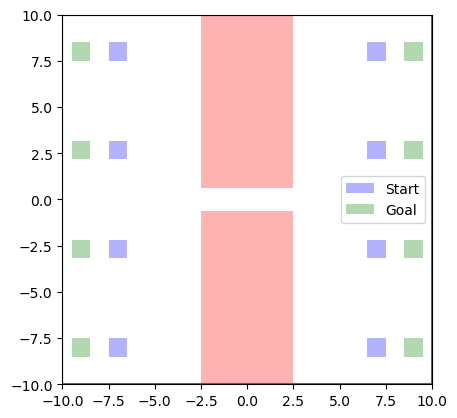

In [2]:
bloating_r = 0.5
vmax = 1.0

N = 8
limits = [(-10,10),(-10,10)] 
n_tunnel = 1

TIMEOUT = 100 # timeout

env = MultiTunnelEnv(n_tunnel = n_tunnel, tunnel_width = bloating_r*2.5,limits=limits, N_agent = N)
draw_env(env)

In [3]:
space_dim = 2
bounds = ob.RealVectorBounds(space_dim)

for axis in range(space_dim):
    bounds.setLow(axis,min(limits[axis]))
    bounds.setHigh(axis,max(limits[axis]))
    
space = ob.RealVectorStateSpace(space_dim)
space.setBounds(bounds)
spaceTime = ob.SpaceTimeStateSpace(space,vmax)

In [4]:
si = ob.SpaceInformation(spaceTime)

In [18]:
def py_to_state(s,space):
    space_dim = len(s)
    x = ob.CompoundState(space)
    for i in range(space_dim):
        x[i] = s[i]
    return x

def state_to_py(s,space_dim = 2):
    return np.array([s[i] for i in range(space_dim)])

def path_to_py(path,space_dim = 2):
    # n_states = path.getStateCount()
    out = [state_to_py(v,space_dim) for v in path]
    return np.array(out).T

class Validator(ob.MotionValidator):
    def __init__(self,si,env,bloating_r):
        super().__init__(si)
        self.env = env
        self.bloating_r = bloating_r
        self.si = si
    def getTime(self,s):
        return self.si.getStateSpace().getStateTime(s)
    
    def checkMotion(self,s1,s2):
        
        x1 = state_to_py(s1[0]) # s[0] is the space component, s[1] is the time component
        x2 = state_to_py(s2[0])

        t1 = self.getTime(s1)
        t2 = self.getTime(s2)

        return t2>=t1 and not has_line_collision(self.env,x1,x2,self.bloating_r)

# Set the object used to check which states in the space are valid
validityChecker = Validator(si,env,bloating_r)
si.setMotionValidator(validityChecker)

si.setup()


start = py_to_state(env.starts[0],spaceTime)

goal = py_to_state(env.goals[0],spaceTime)


# Create a problem instance
pdef = ob.ProblemDefinition(si)

# Set the start and goal states
pdef.setStartAndGoalStates(start(), goal())

feasibleSolFound = {'result':False}
def intermediateSol(_,spath,best_cost): # We know the signature of the callback is like this because we looked into the C++ source code of RRT*
    feasibleSolFound['result'] = True
    return spath, best_cost.value()
pdef.setIntermediateSolutionCallback(ob.ReportIntermediateSolutionFn(intermediateSol))

optimizingPlanner = og.STRRTstar(si)

# Set the problem instance for our planner to solve
optimizingPlanner.setProblemDefinition(pdef)
optimizingPlanner.setup()

# term_condition = ob.exactSolnPlannerTerminationCondition(pdef)
# attempt to solve the planning problem in the given runtime

exactSolutionReached = lambda : feasibleSolFound['result']

term_condition = ob.PlannerTerminationCondition(ob.PlannerTerminationConditionFn(exactSolutionReached))
solved = optimizingPlanner.solve(term_condition)

Debug:   SpaceTimeRRT: Planner range detected to be inf
Info:    SpaceTimeRRT: Starting planning with 1 states already in datastructure
Info:    SpaceTimeRRT: Starting planning with time bound factor 2.00


AttributeError: 'Validator' object has no attribute 'si'

In [6]:
path = pdef.getSolutionPath().getStates()

In [10]:
ts = []
xs = []
for p in path:
    x = p[0]
    xs.append([x[i] for i in range(space_dim)])
    
    ts.append(spaceTime.getStateTime(p))
ts = np.array(ts)
xs = np.array(xs).T

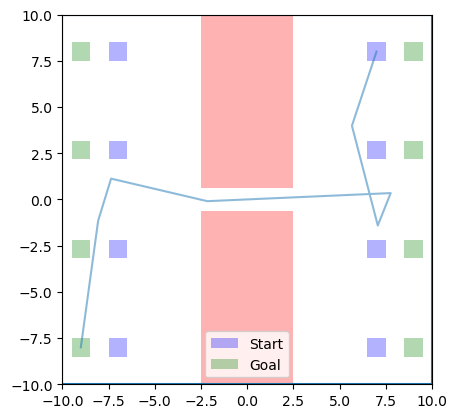

In [13]:
draw_env(env,paths = [xs])


In [16]:
ts

array([ 0.     ,  5.02024, 11.21019, 14.8151 , 28.98172, 19.53863,
       22.05136, 29.05507])

In [15]:
from matplotlib import pyplot as plt
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
from matplotlib import rcParams
import numpy as np

continuous_plans = [(ts,xs)]
plans = np.array(continuous_plans)

exec_tau = 1.0
dt = exec_tau * 0.25
pos_to_ani = []
for cp in plans:
    _,xs = interpolate_positions(*cp,dt)
    pos_to_ani.append(xs)


rcParams['animation.embed_limit'] = 2**128

anim = animation(HG.env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
plt.close() 

/var/folders/4v/bq7m33xj6b9fm2jfm0ngdg3c0000gn/T/ipykernel_62343/1998047015.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plans = np.array(continuous_plans)


ValueError: Number of samples, -37, must be non-negative.